In [1]:
import sys

import pandas as pd
import numpy as np
import scipy as sc
import sklearn as sk

import random
import time
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

from IPython import display

-------------------------


In [2]:
#Алгоритмы
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Помошники
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Визуализация
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Конфигурация визуалиации
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [3]:
df_train = pd.read_csv ('train.csv')
df_test = pd.read_csv ('test.csv')
df_gs = pd.read_csv ('gender_submission.csv')

In [4]:
#Копия обучающей выборки для экспериментов
df_ex = df_train.copy(deep = True)

#Для работы с мусорной обучающей и тестовой выборками
df_cleaner = [df_ex, df_test]

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
356,357,1,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S
612,613,1,3,"Murphy, Miss. Margaret Jane",female,NaN,1,0,367230,15.5000,NaN,Q
162,163,0,3,"Bengtsson, Mr. John Viktor",male,26.0,0,0,347068,7.7750,NaN,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
623,624,0,3,"Hansen, Mr. Henry Damsgaard",male,21.0,0,0,350029,7.8542,NaN,S
327,328,1,2,"Ball, Mrs. (Ada E Hall)",female,36.0,0,0,28551,13.0000,D,S
726,727,1,2,"Renouf, Mrs. Peter Henry (Lillian Jefferys)",female,30.0,3,0,31027,21.0000,NaN,S
363,364,0,3,"Asim, Mr. Adola",male,35.0,0,0,SOTON/O.Q. 3101310,7.0500,NaN,S
254,255,0,3,"Rosblom, Mrs. Viktor (Helena Wilhelmina)",female,41.0,0,2,370129,20.2125,NaN,S
91,92,0,3,"Andreasson, Mr. Paul Edvin",male,20.0,0,0,347466,7.8542,NaN,S


Чистка данных

Корректировка признаков, отклоняющихся от нормы (возраст и стоимость)

Дополнение признаков (работа с нулевыми значениями, мода, медиана, среднее, ско, специцифические критерии, основанные на данных в других признаках)

Создание признаков на основе имеющихся

Стандартизация признаковых значений

In [7]:
print('Нулевые значение в обучающей выборке:\n', df_ex.isnull().sum())
print('-'*10)

print('Нулевые значение в тестовой выборке:\n', df_test.isnull().sum())
print('-'*10)

df_train.describe(include = 'all')

Нулевые значение в обучающей выборке:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Нулевые значение в тестовой выборке:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Renouf, Mr. Peter Henry",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [8]:
# Заполняем и удаляем пропущенные значения в обучающей и тестовой выборке
for dataset in df_cleaner:
    #пропущенные значение возраста заменяем медианой по признакам
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    
    #пропущенные значение места отплытия заменяем модой
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    
    #пропущенные значение цены билета заменяем медианой
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
# Удаляем признаки Номер пассажира, Кабина, Номер билета
drop_column = ['PassengerId', 'Cabin', 'Ticket']
df_ex.drop(drop_column, axis=1, inplace = True)

In [9]:
print(df_ex.isnull().sum())
print("-"*10)
print(df_test.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [10]:
# Создаем новые признаки для выборок
for dataset in df_cleaner:
    #Дискретные переменные
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 
    
    #Дополнительные параметры имени Доктор и т.д.
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    
    #Поквантильная разбивка по стоимости билетов для доп. категориальных признаков
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    
    #Разбивка по возраста через каждые 5 лет для доп. категориальных признаков
    dataset['AgeBin'] = pd.cut (dataset['Age'].astype(int), 5)
    
#Очистим от редких титулов
#print(df_ex['Title'].value_counts())
stat_min = 10 #минимальный размер выборки
title_names = (df_ex['Title'].value_counts() < stat_min)
    
#Функция для поиска малочисленных групп
df_ex['Title'] = df_ex['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(df_ex['Title'].value_counts())
print("-"*10)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------


In [11]:
df_ex.info()
df_test.info()
df_ex.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin       891 non-null category
AgeBin        891 non-null category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null in

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
517,0,3,"Ryan, Mr. Patrick",male,28.0,0,0,24.1500,Q,1,1,Mr,"(14.454, 31.0]","(16.0, 32.0]"
187,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,26.5500,S,1,1,Mr,"(14.454, 31.0]","(32.0, 48.0]"
91,0,3,"Andreasson, Mr. Paul Edvin",male,20.0,0,0,7.8542,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
425,0,3,"Wiseman, Mr. Phillippe",male,28.0,0,0,7.2500,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
523,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,57.9792,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
208,1,3,"Carr, Miss. Helen ""Ellen""",female,16.0,0,0,7.7500,Q,1,1,Miss,"(-0.001, 7.91]","(-0.08, 16.0]"
683,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,46.9000,S,8,0,Mr,"(31.0, 512.329]","(-0.08, 16.0]"
812,0,2,"Slemen, Mr. Richard James",male,35.0,0,0,10.5000,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]"
837,0,3,"Sirota, Mr. Maurice",male,28.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
44,1,3,"Devaney, Miss. Margaret Delia",female,19.0,0,0,7.8792,Q,1,1,Miss,"(-0.001, 7.91]","(16.0, 32.0]"


Конвертируем категориальные признаки в некоторые фиктивные переменные для мат. анализа.

In [12]:
#для категориальных данных
label = LabelEncoder()
for dataset in df_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
#определим переменную Y - целевой признак
Target = ['Survived']

#определим переменную X - имеющиеся признаки
df_ex1 = ['Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
df_ex1_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare']
df_ex_xy = Target + df_ex1 #объединили переменные
print('Original X Y: ', df_ex_xy, '\n')

#определим переменные X, удалив непрерывные признаки
df_ex_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
df_ex_xy_bin = Target + df_ex1
print('Bin X Y: ', df_ex_xy_bin, '\n')

#определим переменные X и Y для фиктивных признаков
df_dummy = pd.get_dummies(df_ex[df_ex1])
df_x_dummy = df_dummy.columns.tolist()
df_ex1_xy_dummy = Target + df_x_dummy
print('Dummy X Y: ', df_ex1_xy_dummy, '\n')

df_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


Повторно проверим данные

In [13]:
print('Нулевые колонки в обучающей выборке: \n', df_ex.isnull().sum())
print("-"*10)
print (df_ex.info())
print("-"*10)

print('Нулевые колонки в тестовой выборке: \n', df_test.isnull().sum())
print("-"*10)
print (df_test.info())
print("-"*10)

df_train.describe(include = 'all')

Нулевые колонки в обучающей выборке: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 non-null c

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Renouf, Mr. Peter Henry",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [14]:
#Разделим нашу обучающую выборку на обучающую и тестовую 75/25
train_x, test_x, train_y, test_y = model_selection.train_test_split(df_ex[df_ex1_calc], df_ex[Target], random_state = 0)
train_x_bin, test_x_bin, train_y_bin, test_y_bin = model_selection.train_test_split(df_ex[df_ex_bin], df_ex[Target], random_state = 0)
train_x_dummy, test_x_dummy, train_y_dummy, test_y_dummy = model_selection.train_test_split(df_dummy[df_x_dummy], df_ex[Target], random_state = 0)

print("Data1 Shape: {}".format(df_ex.shape))
print("Train1 Shape: {}".format(train_x.shape))
print("Test1 Shape: {}".format(test_x.shape))

train_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


Статистическое исследование данных

In [15]:
#корреляция дискретных и целевого признаков 
for x in df_ex1:
    if df_ex[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(df_ex[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')

print(pd.crosstab(df_ex['Title'], df_ex[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1 

In [16]:
df_ex.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,2,3,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,0,4,2,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]",0,2,2,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,2,4,2,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]",1,2,3,2,1


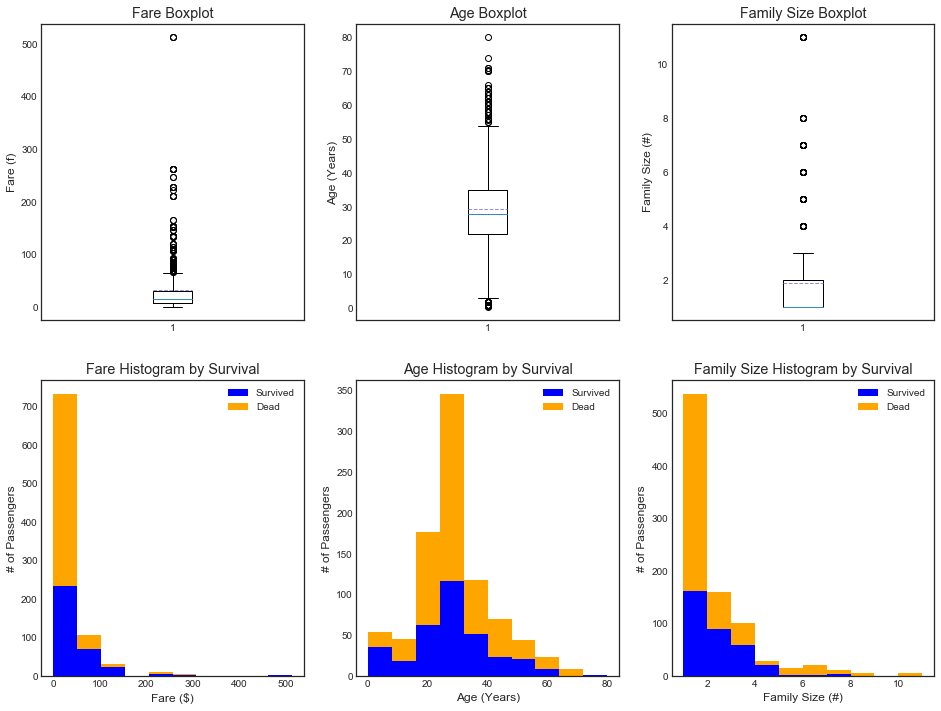

In [17]:
#Визуализация распределения данных
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=df_ex['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare (f)')

plt.subplot(232)
plt.boxplot(df_ex['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(df_ex['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [df_ex[df_ex['Survived']==1]['Fare'], df_ex[df_ex['Survived']==0]['Fare']], 
         stacked=True, color = ['blue','orange'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [df_ex[df_ex['Survived']==1]['Age'], df_ex[df_ex['Survived']==0]['Age']], 
         stacked=True, color = ['blue','orange'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [df_ex[df_ex['Survived']==1]['FamilySize'], df_ex[df_ex['Survived']==0]['FamilySize']], 
         stacked=True, color = ['blue','orange'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

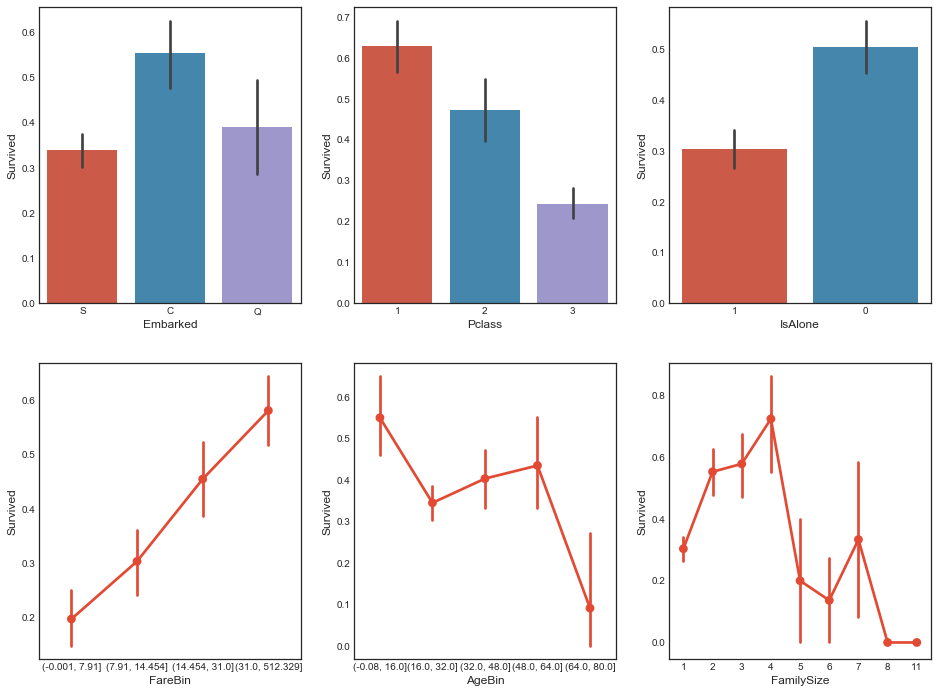

In [18]:
#Используем seaborn
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=df_ex, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=df_ex, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=df_ex, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=df_ex, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=df_ex, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=df_ex, ax = saxis[1,2])

Text(0.5,1,'Pclass vs Family Size Survival Comparison')

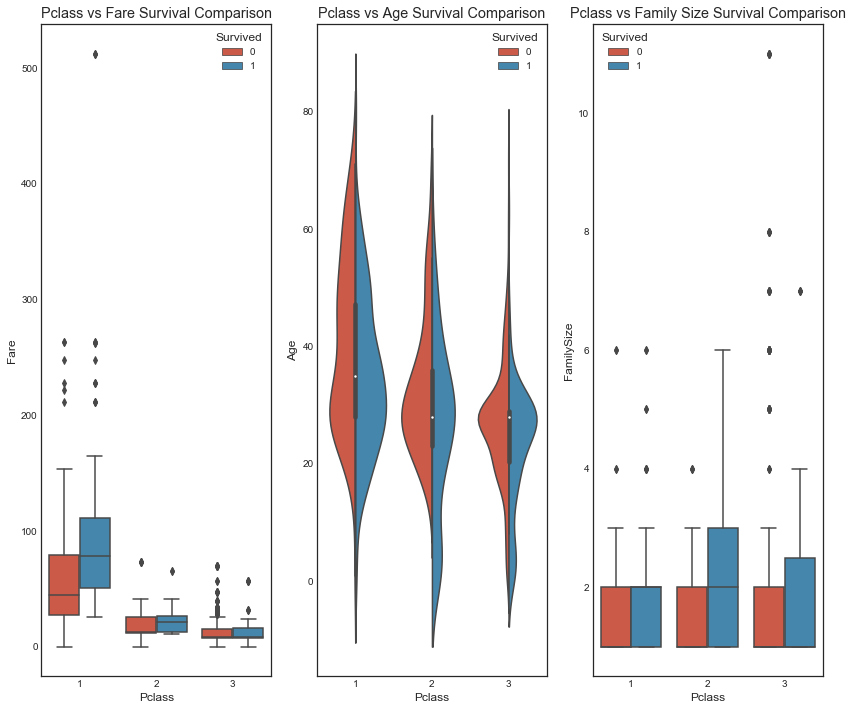

In [19]:
#Визуализация класса билета
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,12))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data=df_ex, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data=df_ex, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data=df_ex, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

Text(0.5,1,'Sex vs IsAlone Survival Comparison')

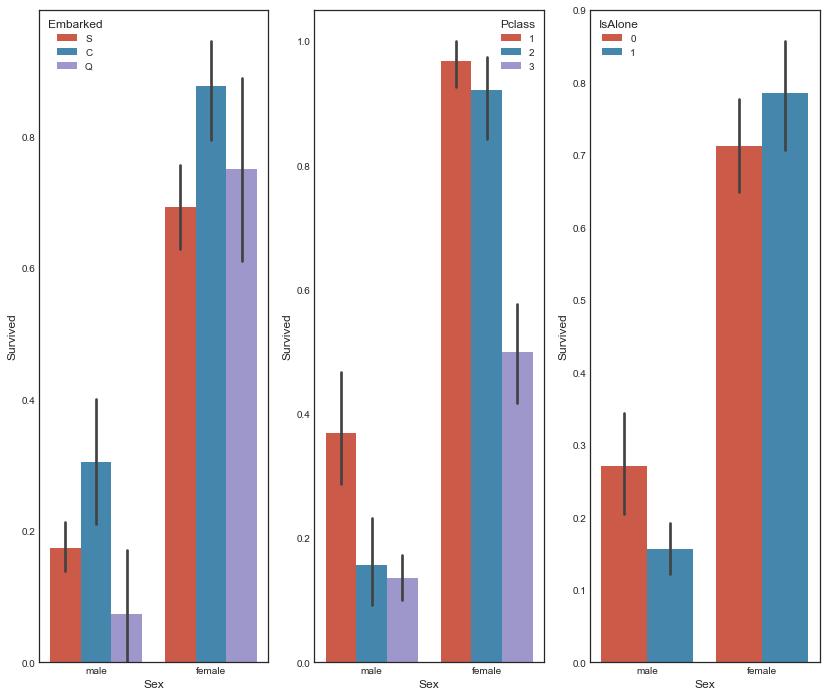

In [20]:
#Визуализация по классу пол
fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=df_ex, ax = qaxis[0])
axis1.set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=df_ex, ax  = qaxis[1])
axis1.set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=df_ex, ax  = qaxis[2])
axis1.set_title('Sex vs IsAlone Survival Comparison')

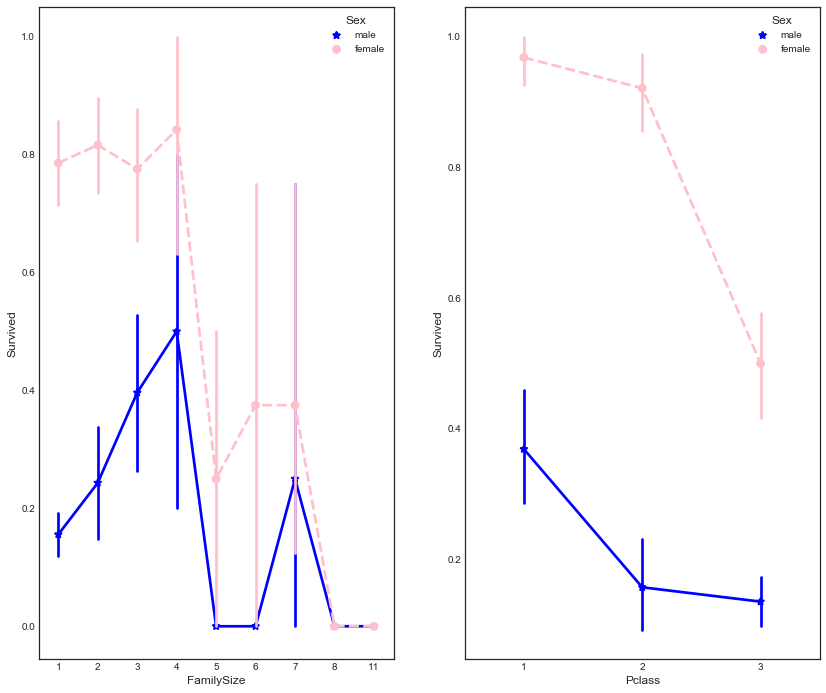

In [21]:
fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(14,12))

#Зависимость размера семьи и пола к целевому признаку
sns.pointplot(x="FamilySize", y="Survived", hue="Sex", data=df_ex,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)

#Зависимость класса билета и пола к целевому признаку
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=df_ex,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)

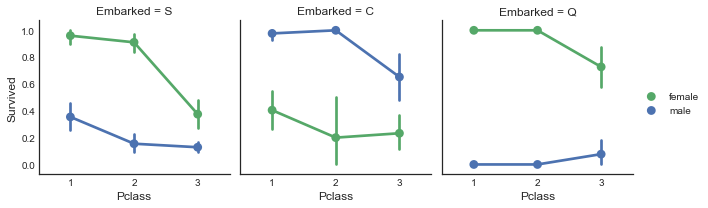

In [22]:
#Зависимость порта посадки, класса билета, пола к целевому признаку
e = sns.FacetGrid(df_ex, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

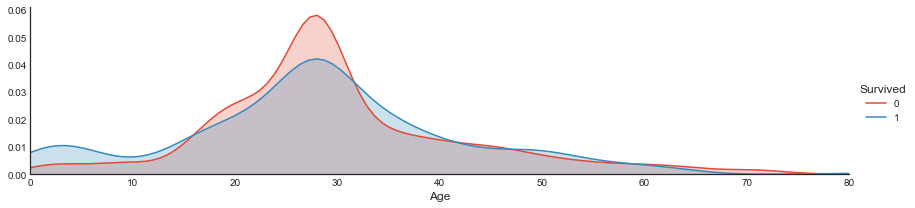

In [23]:
#распределение возраста пассажиров среди тех выживших и утонувших
a = sns.FacetGrid(df_ex, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , df_ex['Age'].max()))
a.add_legend()

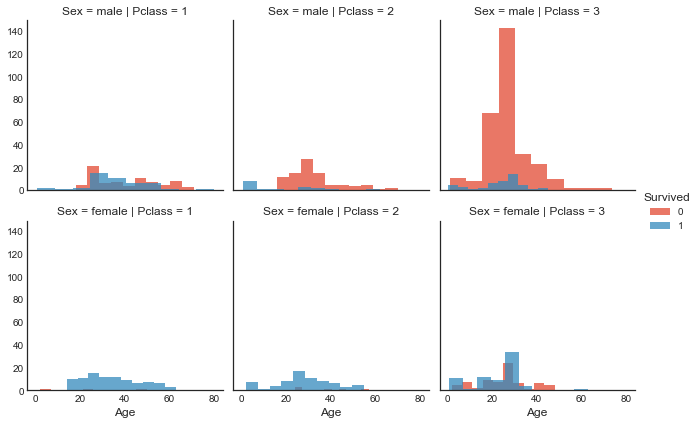

In [24]:
#Гистограмма для сравнения пола, класса билета и возраста к целевому признаку
h = sns.FacetGrid(df_ex, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

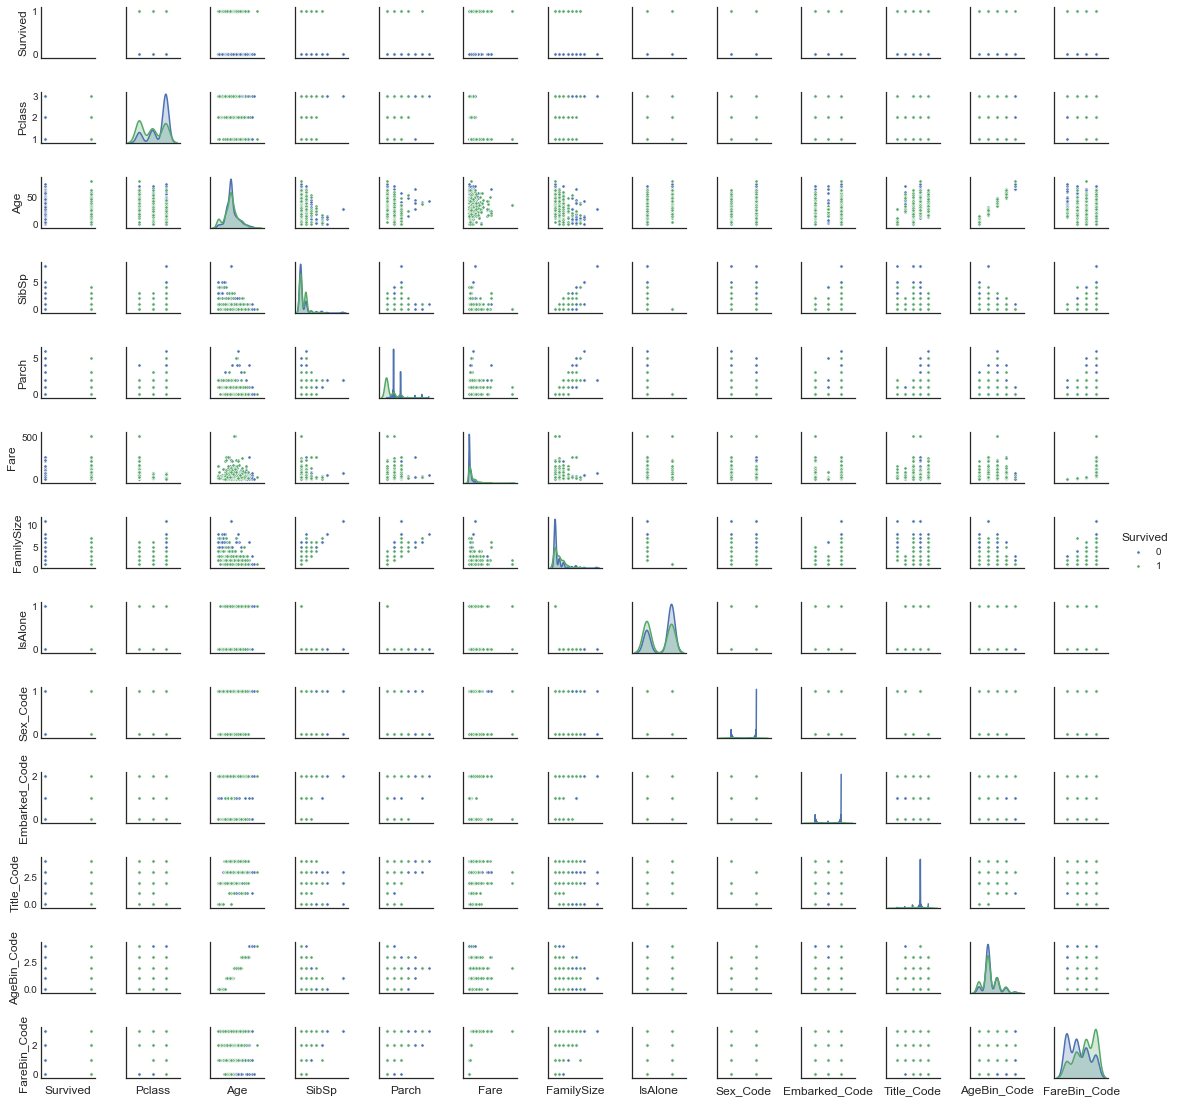

In [26]:
#нарисуем все графики из нашего набора данных
pp = sns.pairplot(df_ex, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
pp.set(xticklabels=[])

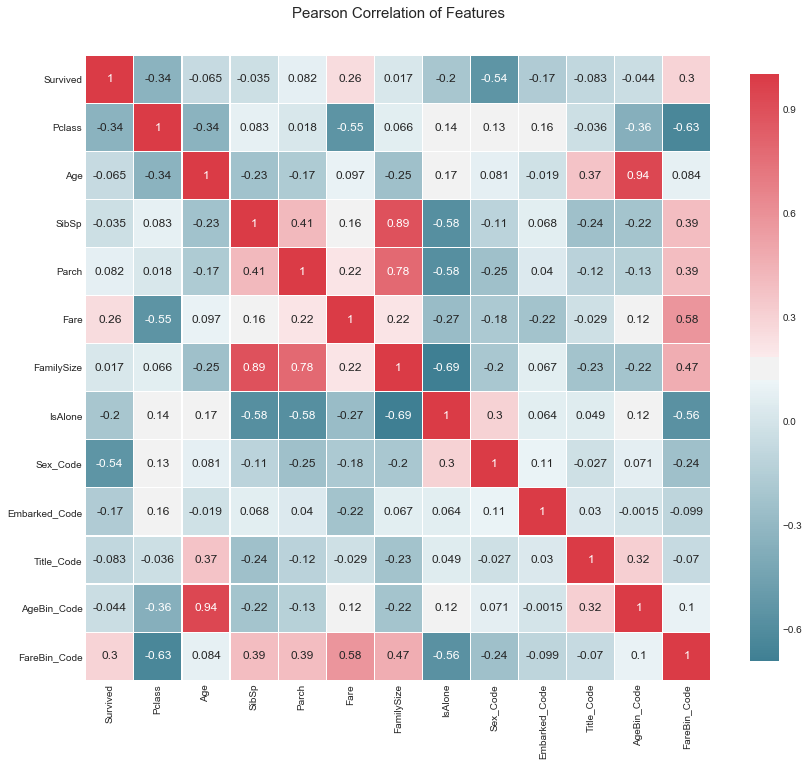

In [27]:
#визуализируем корреляции признаков через heatmap
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df_ex)

Попробуем отработать основные алгоритмы обучения на наших данных и выберем наиболее хорошо отрабатывающие.


In [35]:
#Выбор и инициализация модели MLA - Machine Learning Algorithm
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Гауссовские процессы
    gaussian_process.GaussianProcessClassifier(),
    
    #Geberal linear models/Основные модели линейной регрессии
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    #Стохастический градиентный бустинг
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Наивный Байес
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Метод ближайших соседей
    neighbors.KNeighborsClassifier(),
    
    #Метод опорных векторов
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Деревья решений
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Дискриминантный анализ
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]


#Рассплитуем наш набор данных
cv_split = model_selection.ShuffleSplit (n_splits = 10, test_size = .3, train_size = .6, random_state = 0)

#Создадим таблицу для сравнения метрик
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#Создадим таблицу для сравнения прогнозов
MLA_predict = df_ex[Target]

#Проиндексируем алгоритмы и сохраним результаты в таблице
row_index = 0
for alg in MLA:
    
    #название и параметр
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #оценочная модель с кросс валидацией
    cv_results = model_selection.cross_validate(alg, df_ex[df_ex_bin], df_ex[Target], cv = cv_split)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    
    #если это несмещенная случайная выборка, тогда +/- 3 стандартных отклонения от среднего статистически охватывает 99,7% подмножества  
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
   

    #сохраним предсказания
    alg.fit(df_ex[df_ex_bin], df_ex[Target])
    MLA_predict[MLA_name] = alg.predict(df_ex[df_ex_bin])
    
    row_index+=1

#напечатаем и отсортируем таблицу
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.856367,0.829478,0.0527546,0.0308979
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837266,0.826119,0.0453876,0.0311942
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.835768,0.822761,0.0493681,0.0370456
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.866667,0.822015,0.0529916,0.0541962
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.891948,0.822015,0.0469749,0.0122545
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.821642,0.0505098,0.0016959
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895131,0.821269,0.0616079,0.0114609
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.889513,0.819403,0.0605306,0.0128997
18,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.816791,0.0630155,0.00185001
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.0690863,0.00194702


Text(0,0.5,'Algorithm')

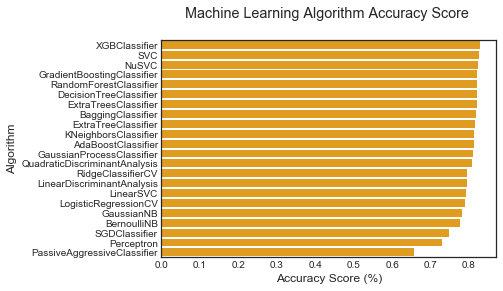

In [37]:
#Отрисуем результаты с помощью seaborn
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'orange')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

Исходя из наших данных, мы можем предсказать выживших пассажиров с точностью около 83%

In [41]:
#проитерируем наш датафрейм на гипотетической модели подбрасывания монетки
for index, row in df_ex.iterrows(): 
    #генератор случайных чисел
    if random.random() > .5:     # Random float x, 0.0 <= x < 1.0    
        df_ex.set_value(index, 'Random_Predict', 1) #прогноз на выжившего/1
    else: 
        df_ex.set_value(index, 'Random_Predict', 0) #прогноз на погибшего/0

#нумерация случайно предполагаемы выживших, используем 1 - верное предположение, 0 - неверное
#средняя по колонкам будет равна точности
df_ex['Random_Score'] = 0 #предположим, что прогноз неверен
df_ex.loc[(df_ex['Survived'] == df_ex['Random_Predict']), 'Random_Score'] = 1 #установим 1 для верного прогноза
print('Coin Flip Model Accuracy: {:.2f}%'.format(df_ex['Random_Score'].mean()*100))

#также мы можем использовать scikit accuracy score дабы уменьшить размер кода
print('Coin Flip Model Accuracy w/SciKit: {:.2f}%'.format(metrics.accuracy_score(df_ex['Survived'], df_ex['Random_Predict'])*100))

Coin Flip Model Accuracy: 50.51%
Coin Flip Model Accuracy w/SciKit: 50.51%


In [42]:
#сделаем сводную таблицу
pivot_female = df_ex[df_ex.Sex=='female'].groupby(['Sex','Pclass', 'Embarked','FareBin'])['Survived'].mean()
print('Survival Decision Tree w/Female Node: \n',pivot_female)

pivot_male = df_ex[df_ex.Sex=='male'].groupby(['Sex','Title'])['Survived'].mean()
print('\n\nSurvival Decision Tree w/Male Node: \n',pivot_male)

Survival Decision Tree w/Female Node: 
 Sex     Pclass  Embarked  FareBin        
female  1       C         (14.454, 31.0]     0.666667
                          (31.0, 512.329]    1.000000
                Q         (31.0, 512.329]    1.000000
                S         (14.454, 31.0]     1.000000
                          (31.0, 512.329]    0.955556
        2       C         (7.91, 14.454]     1.000000
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    1.000000
                Q         (7.91, 14.454]     1.000000
                S         (7.91, 14.454]     0.875000
                          (14.454, 31.0]     0.916667
                          (31.0, 512.329]    1.000000
        3       C         (-0.001, 7.91]     1.000000
                          (7.91, 14.454]     0.428571
                          (14.454, 31.0]     0.666667
                Q         (-0.001, 7.91]     0.750000
                          (7.91, 14.454]     0.500000


In [44]:
#простая модель решающего дерева на коленке
def mytree(df):
    
    #инициализируем таблицу для прогнозов
    Model = pd.DataFrame(data = {'Predict':[]})
    male_title = ['Master'] #титулы выживших
    
    for index, row in df.iterrows():

        #Вопрос №1 Вы на Титанике?; Большинство погибло
        Model.loc[index, 'Predict'] = 0

        #Вопрос №2 Вы женщина?; Большинство выжило
        if (df.loc[index, 'Sex'] == 'female'):
                  Model.loc[index, 'Predict'] = 1

        #Вопрос №3А Женщина - Класс и Вопрос №4 Порт посадки дает минимум прироста информации

        #Вопрос №5В Женщина - Квантиль стоимости билета       
        if ((df.loc[index, 'Sex'] == 'female') & 
            (df.loc[index, 'Pclass'] == 3) & 
            (df.loc[index, 'Embarked'] == 'S')  &
            (df.loc[index, 'Fare'] > 8)

           ):
                  Model.loc[index, 'Predict'] = 0

        #Вопрос №3В Мужчина: Титул; смещает квантиль на .5 
        if ((df.loc[index, 'Sex'] == 'male') &
            (df.loc[index, 'Title'] in male_title)
            ):
            Model.loc[index, 'Predict'] = 1
        
        
    return Model


#Модель данных
Tree_Predict = mytree(df_ex)
print('Decision Tree Model Accuracy/Precision Score: {:.2f}%\n'.format(metrics.accuracy_score(df_ex['Survived'], Tree_Predict)*100))


#Суммарный отчет по точности, где recall - TP/(TP+FP) - все верно угаданные прогнозы, деленные на все верно угаданные + неверноугаданные (полнота)
#Метрика F1 - среднее гармоническое по прогнозам и полноте
print(metrics.classification_report(df_ex['Survived'], Tree_Predict))

Decision Tree Model Accuracy/Precision Score: 82.04%

             precision    recall  f1-score   support

          0       0.82      0.91      0.86       549
          1       0.82      0.68      0.75       342

avg / total       0.82      0.82      0.82       891



Confusion matrix, without normalization
[[497  52]
 [108 234]]
Normalized confusion matrix
[[0.91 0.09]
 [0.32 0.68]]


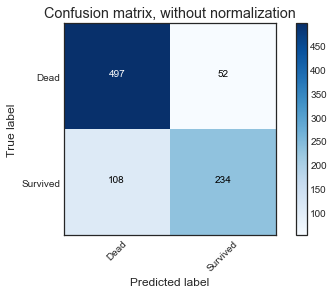

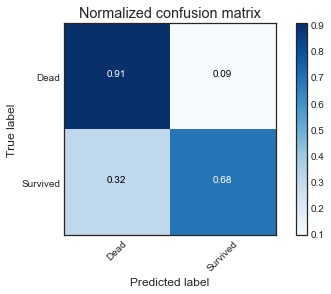

In [46]:
#Отрисуем точность суммарно
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Высчитаем матрицу неточностей
cnf_matrix = metrics.confusion_matrix(df_ex['Survived'], Tree_Predict)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']
#Отрисуем ненормализованную матрицу неточностей
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

#Отрисуем нормализованную
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')